# ETA interpolation 

In [1]:
#add the aare build folder to sys.path to make it visible to python
import sys; sys.path.append('/home/l_msdetect/erik/aare/build')
from helpers import nb_aare_version
nb_aare_version()

import pickle

#Our normal python imports
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import boost_histogram as bh
import time

import tifffile

#Directly import what we need from aare
from aare import File, ClusterFile
from aare._aare import calculate_eta2, Interpolator
import aare

# old data with frame number for each cluster, need custom reader
# base = Path('/mnt/sls_det_storage/moench_data/tomcat_nanoscope_21042020/09_Moench_650um/')
# cluster_fname = base/'acq_interp_center_3.8Mfr_200V.clust'
# flatfield_fname = base/'flatfield_center_200_d0_f000000000000_0.clust'

#TOMO of eye
# base = Path('/mnt/sls_det_storage/moench_data/TriestePEPI_202502/pepi_data/CT_eye')
# cluster_fname = base/'BT_0.clust'
# ff_fname = base/'BT_4000.clust'

#bee
base = Path('/mnt/sls_det_storage/moench_data/TriestePEPI_202502/pepi_data/Tuesday_PhD/imaging')
ff_fname = base/'Bees_head_flat_10.clust'
cluster_fname= base/'Bees_head_10.clust'
eta_fname = "/home/l_msdetect/erik/tmp/eta_hist_bee.pkl"
ff_hist_fname = "/home/l_msdetect/erik/tmp/ff_hist_bee.pkl"
ff_hitmap_hist_fname = "/home/l_msdetect/erik/tmp/ff_hitmap_hist_bee.pkl"
img_hist_fname = "/home/l_msdetect/erik/tmp/img_hist_bee.pkl"
img_hitmap_hist_fname = "/home/l_msdetect/erik/tmp/img_hitmap_hist_bee.pkl"

Example run on: **2025-04-01 15:37** with aare: **dev**

## Read .tiff file as reference

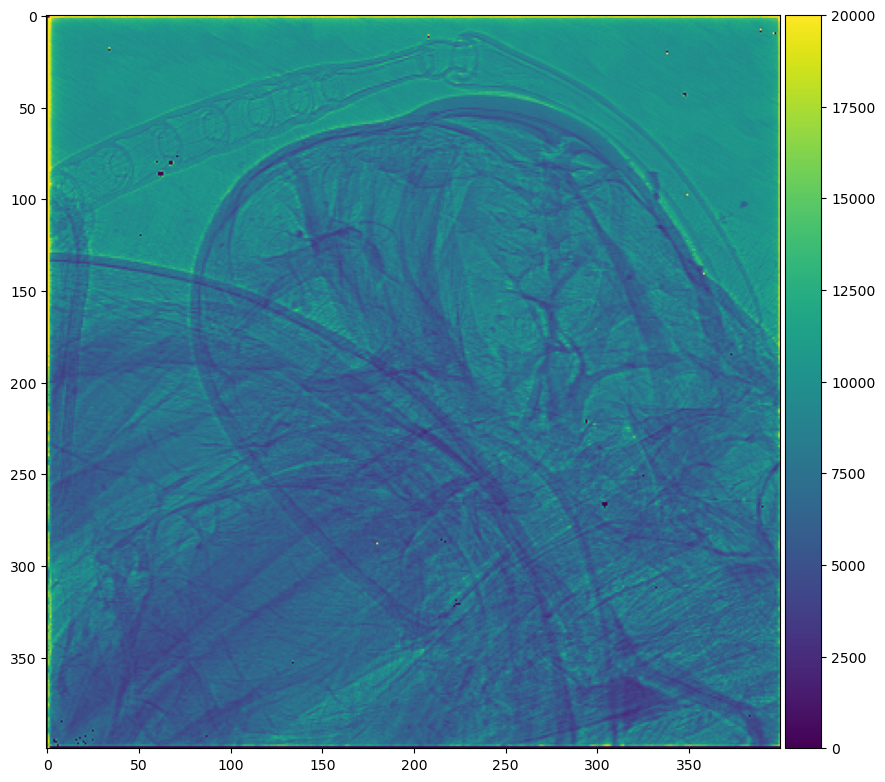

In [2]:
img = tifffile.imread(cluster_fname.with_suffix('.tiff'))
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(img)
im.set_clim(0,2e4)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

## Fill a 3D histogram with the ETA values

- when using eta3 ...
- For polychromatic images make a 3D histogram with x,y, energy 

File has up to: 4940 chunks
EOF reached/5000

Processing eta took: 724.883s


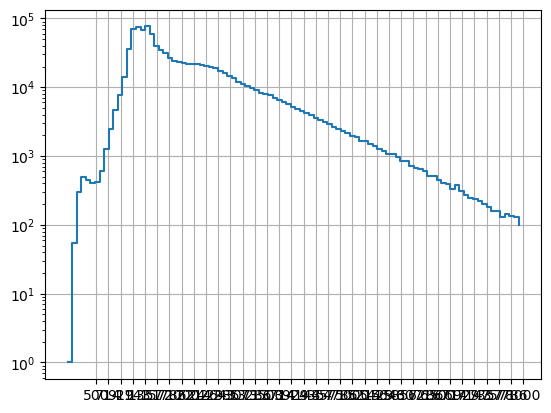

In [24]:
make_eta = True
save_eta = True

#configure the eta histogram
n_bins = 400
ax_min = -0.2
ax_max = 1.2
e_min = 500  
e_max = 8000
e_bins = 35


#How many clusters to load at a time and maximum number of chinks
chunk_size = 1_000_000
n_chunks = 5000

#Estimate how many clusters there are in the file
forecase_chunks = ff_fname.stat().st_size/40/chunk_size
print(f'File has up to: {forecase_chunks:.0f} chunks')

gain = 155

#Histogram to hold the ETA value per energy bin
hist = bh.Histogram(
    bh.axis.Regular(n_bins, ax_min, ax_max), 
    bh.axis.Regular(n_bins, ax_min, ax_max),
    bh.axis.Regular(e_bins, e_min, e_max),
)

#ROI for reading clusters
roi = aare.ROI(xmin = 10, xmax = 390, ymin = 10, ymax = 390)

ebins = np.array(hist.axes.edges.T[2].flat)


first = True
if make_eta:
    t0 = time.perf_counter()
    with ClusterFile(ff_fname) as f:
        f.set_roi(roi)
        for i in range(n_chunks):
            clusters = f.read_clusters(chunk_size)
#             clusters = f.read_clusters(chunk_size)
            if clusters.size == 0:
                print(f'EOF reached')
                break
            #TODO!Fuse these calculations in C++
            eta2 = calculate_eta2(clusters)
            energy = clusters.sum_2x2()
            hist.fill(eta2[:,0], eta2[:,1], energy)

            if first:
                first = False
                hist2 = bh.Histogram(
                    bh.axis.Regular(100, 0, 8000)
                )
                hist2.fill(clusters.sum_2x2())
                m = hist2.values().max()
                fig, ax = plt.subplots()
                ax.step(hist2.axes[0].edges[:-1], hist2.values(), where="post");
                ax.set_xticks(hist.axes[2].edges)
                ax.grid()
                ax.set_yscale('log')
            print(f'chunk: {i}/{n_chunks}', end = '\r')
    print()

    t_elapsed = time.perf_counter()-t0
    print(f'Processing eta took: {t_elapsed:.3f}s')
    if save_eta:
        with open(eta_fname, "wb") as f:
            pickle.dump(hist, f)
else:
    #No reprocessing of the eta, just load the histogram
    with open(eta_fname, "rb") as f:
        hist = pickle.load(f)

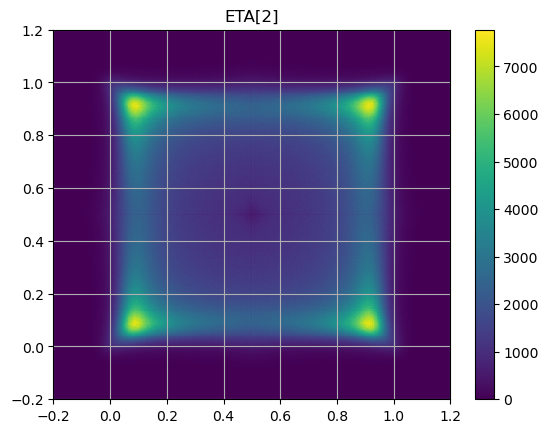

In [25]:
energy_index = 2
data = hist.view()[:,:,energy_index]
x = hist.axes.edges.T[0].flat
y = hist.axes.edges.T[1].flat

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x,y,data)
fig.colorbar(mesh)
ax.set_title(f'ETA[{energy_index}]')
ax.grid()

## Visualize the ETA

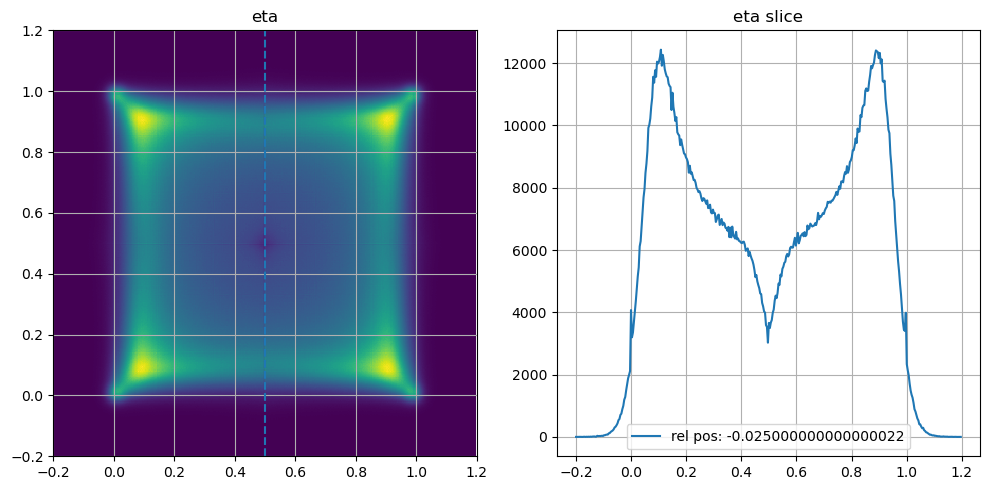

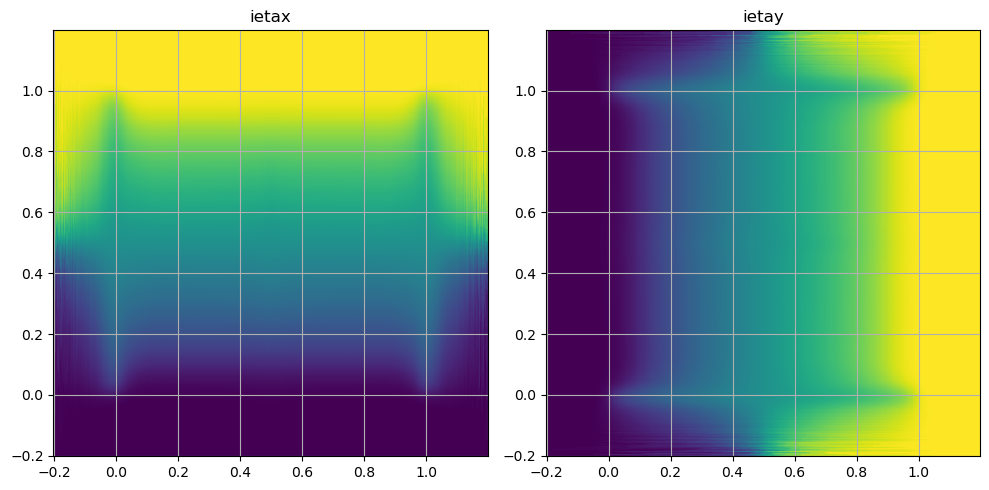

In [26]:
vis_index = 3
x_index = 200

plot_prep = True
eta = hist.view().copy()
etabinsx = np.array(hist.axes.edges.T[0].flat)
etabinsy = np.array(hist.axes.edges.T[1].flat)
ebins = np.array(hist.axes.edges.T[2].flat)

x_pos = etabinsx[x_index]

if plot_prep:
    fig, axs = plt.subplots(1,2, figsize = (10,5))
    axs[0].pcolormesh(etabinsx[:-1], etabinsy[:-1], eta[:,:,vis_index])
    axs[0].set_xlim(-0.2,1.2)
    axs[0].set_ylim(-0.2,1.2)
    axs[0].set_title('eta')
    axs[0].plot([x_pos,x_pos], [-0.2,1.2], '--')
    axs[1].plot(etabinsx[:-1], eta[:,x_index, vis_index], label = f'rel pos: {etabinsx[50]}')
    axs[1].set_title('eta slice')
    axs[1].legend()
    for ax in axs:
        ax.grid()
    fig.tight_layout()

p = Interpolator(eta, etabinsx[:-1], etabinsy[:-1], ebins[:-1]) 

ietax=p.get_ietax()
ietay=p.get_ietay()

if plot_prep:
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].pcolormesh(etabinsx[:-1], etabinsy[:-1],ietax[:,:,vis_index])
    axs[1].pcolormesh(etabinsx[:-1], etabinsy[:-1],ietay[:,:,vis_index])
    axs[0].set_title('ietax')
    axs[1].set_title('ietay')
    for ax in axs:
        ax.grid()
    fig.tight_layout()

ebins = np.array(hist.axes.edges.T[2].flat)


## Flatfield

In [27]:
n_bins = 2000
xmin = 0
xmax = 400
scale = n_bins**2/400**2

make_flatfield = True
chunk_size = 1_000_000
forecase_chunks = ff_fname.stat().st_size/40/chunk_size
print(f'File has up to: {forecase_chunks:.0f} chunks')

if make_flatfield:
    t0 = time.perf_counter()
    hist = bh.Histogram(
        bh.axis.Regular(n_bins, xmin, xmax), 
        bh.axis.Regular(n_bins, xmin, xmax),
        bh.axis.Regular(e_bins, e_min, e_max)
    )
    
    hit_hist = bh.Histogram(
        bh.axis.Regular(400, 0-.5, 400-.5), 
        bh.axis.Regular(400, 0-.5, 400-.5),
        bh.axis.Regular(e_bins, e_min, e_max)
    )


    hm = np.zeros((400,400))
    i = 0
    with ClusterFile(ff_fname, chunk_size = chunk_size) as f:
        for clusters in f:
            photons = p.interpolate(clusters)
            arr = np.array(clusters, copy=False)
            hist.fill(photons['y'], photons['x'], photons['energy'])
            hit_hist.fill(arr['y'], arr['x'], clusters.sum_2x2())
            i+=1
            if i==n_chunks:
                break
            print(f'chunk: {i}/{n_chunks}', end = '\r')
    with open(ff_hist_fname, "wb") as f:
        pickle.dump(hist, f)   
    with open(ff_hitmap_hist_fname, "wb") as f:
        pickle.dump(hit_hist, f) 
    t_elapsed = time.perf_counter()-t0
    print(f'Processed flatfiled in {t_elapsed:.3f}s')
else:
    with open(ff_hist_fname, "rb") as f:
        hist = pickle.load(f)
    with open(ff_hitmap_hist_fname, "rb") as f:
        hit_hist = pickle.load(f)




File has up to: 4940 chunks
Processed flatfiled in 2008.976s


Text(0.5, 1.0, 'flatfield[:, : 3]')

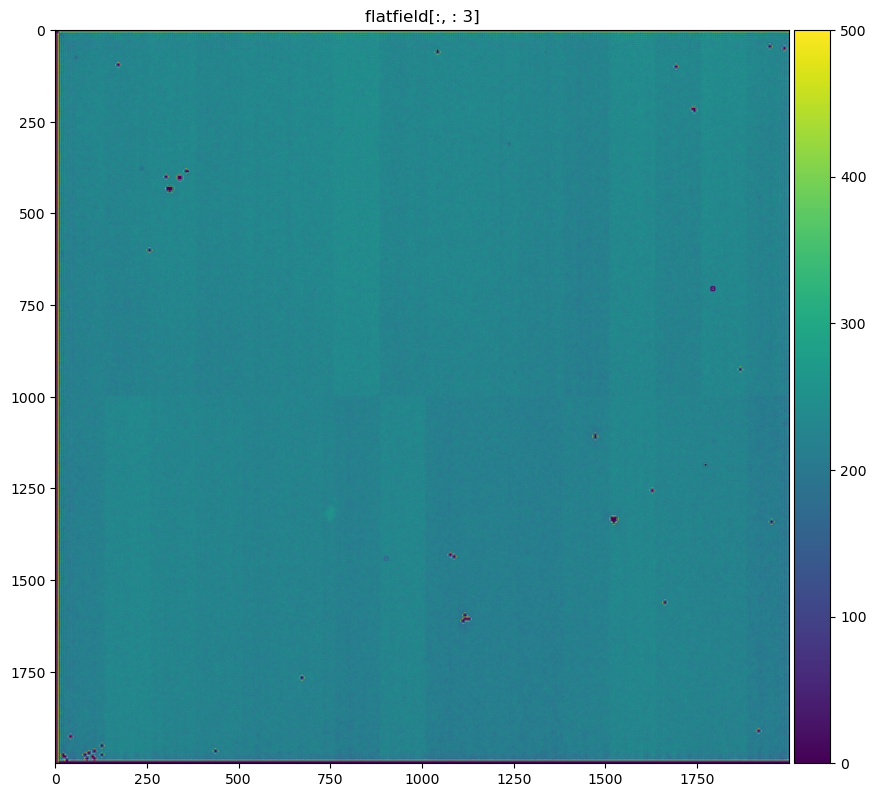

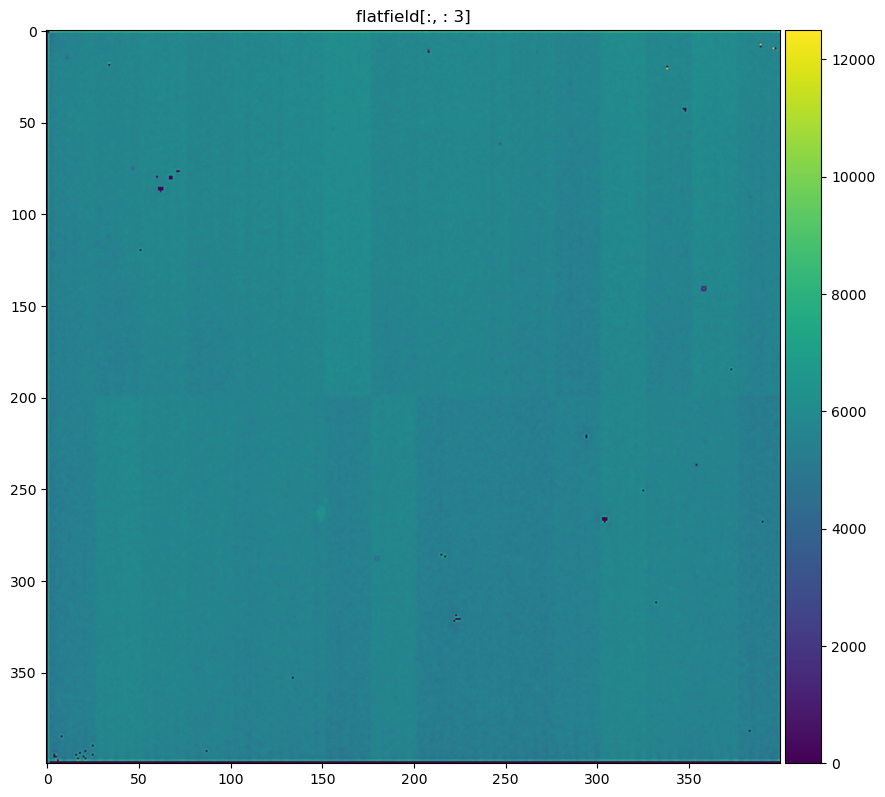

In [30]:
ff_hitmap = hit_hist.view().copy()
flatfield = hist.view().copy()
clim = np.array((0,500))
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(flatfield[:,:,vis_index])

im.set_clim(clim)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title(f'flatfield[:, : {vis_index}]')

fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(ff_hitmap[:,:,vis_index])

im.set_clim(clim*scale)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title(f'flatfield[:, : {vis_index}]')

In [31]:
make_image = True
chunk_size = 1_000_000
forecase_chunks = cluster_fname.stat().st_size/40/chunk_size
print(f'File has up to: {forecase_chunks:.0f} chunks')


if make_image:
    t0 = time.perf_counter()
    hist = bh.Histogram(
        bh.axis.Regular(n_bins, xmin, xmax), 
        bh.axis.Regular(n_bins, xmin, xmax),
        bh.axis.Regular(e_bins, e_min, e_max)
    )


    hit_hist = bh.Histogram(
        bh.axis.Regular(400, 0-.5, 400-.5), 
        bh.axis.Regular(400, 0-.5, 400-.5),
        bh.axis.Regular(e_bins, e_min, e_max)
    )
    i = 0
    with ClusterFile(cluster_fname, chunk_size = chunk_size ) as f:
        for clusters in f:
            photons = p.interpolate(clusters)
            arr = np.array(clusters, copy=False)
            hit_hist.fill(arr['y'], arr['x'], clusters.sum_2x2())
            hist.fill(photons['y'], photons['x'], photons['energy'])
            i+=1
            if i==n_chunks:
                break
            print(f'chunk: {i}/{n_chunks}', end = '\r')

    
    with open(img_hist_fname, "wb") as f:
        pickle.dump(hist, f)
    with open(img_hitmap_hist_fname, "wb") as f:
        pickle.dump(hit_hist, f)
        
    t_elapsed = time.perf_counter()-t0
    print(f'Processing image: {t_elapsed:.3f}s')
else:
    with open(img_hist_fname, "rb") as f:
        hist = pickle.load(f)
    with open(img_hitmap_hist_fname, "rb") as f:
        hit_hist = pickle.load(f)
        
image = hist.view().copy()
hitmap = hit_hist.view().copy()

File has up to: 1241 chunks
Processing image: 542.247s


Text(0.5, 1.0, 'hitmap[:,:,3]')

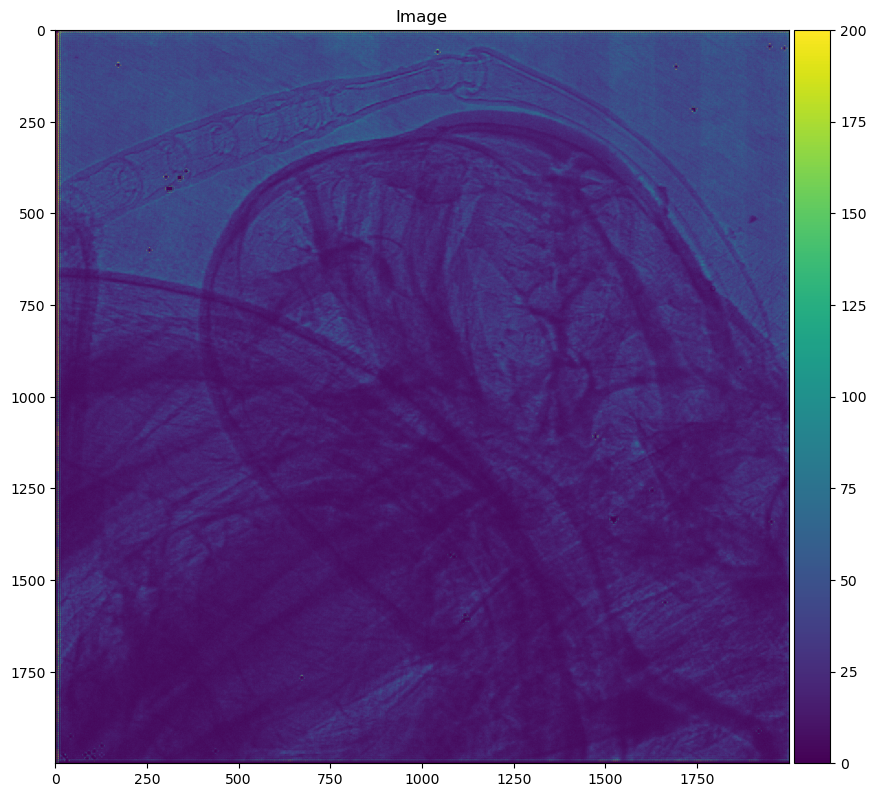

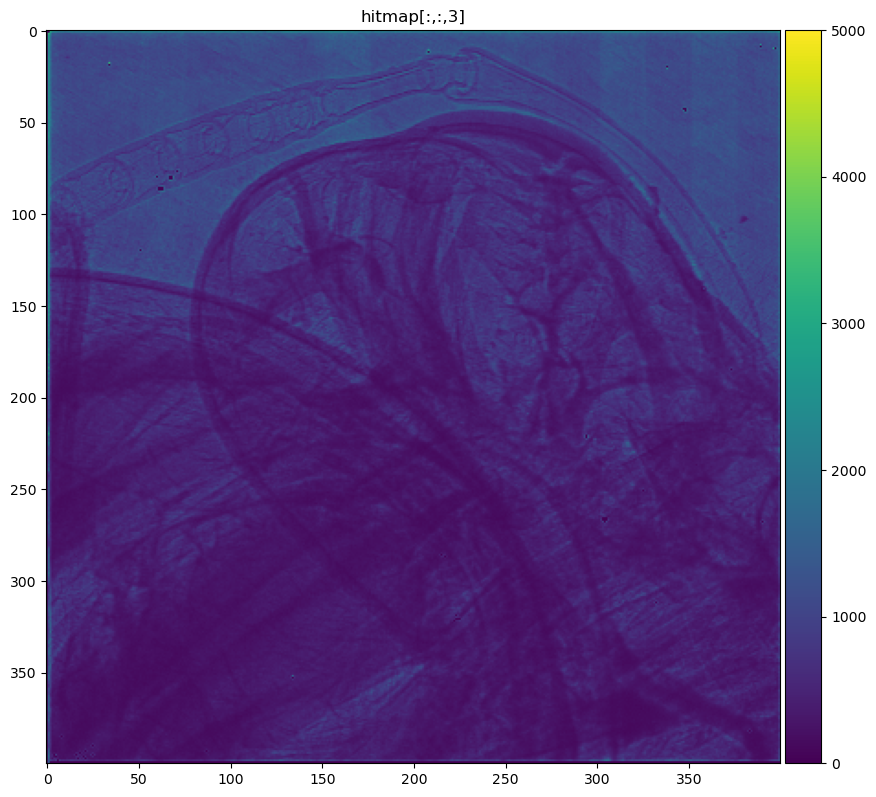

In [32]:
clim = np.array((0,200))
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(image[:,:,vis_index])
im.set_clim(clim)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('Image')

fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(hitmap[:,:,vis_index])
im.set_clim(clim*scale)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title(f'hitmap[:,:,{vis_index}]')

In [33]:
#do proper flatfield correction
#1/(a/a.mean())
# for e in hist.axes[2]:
#     print(e)
# print(hist.view().shape)
# image = hist.view()[:,:,2:3].sum(axis = 2)

ff = np.zeros(flatfield.shape)
for i in range(flatfield.shape[2]):
    ff[:,:,i] = flatfield[:,:,i]/flatfield[:,:,i].mean()

# ff= flatfield/flatfield.mean()
ff[ff==0] = 1
ff = 1/ff
interpolated = image*ff
print(interpolated.shape)

(2000, 2000, 35)


Text(0.5, 1.0, 'Hitmap')

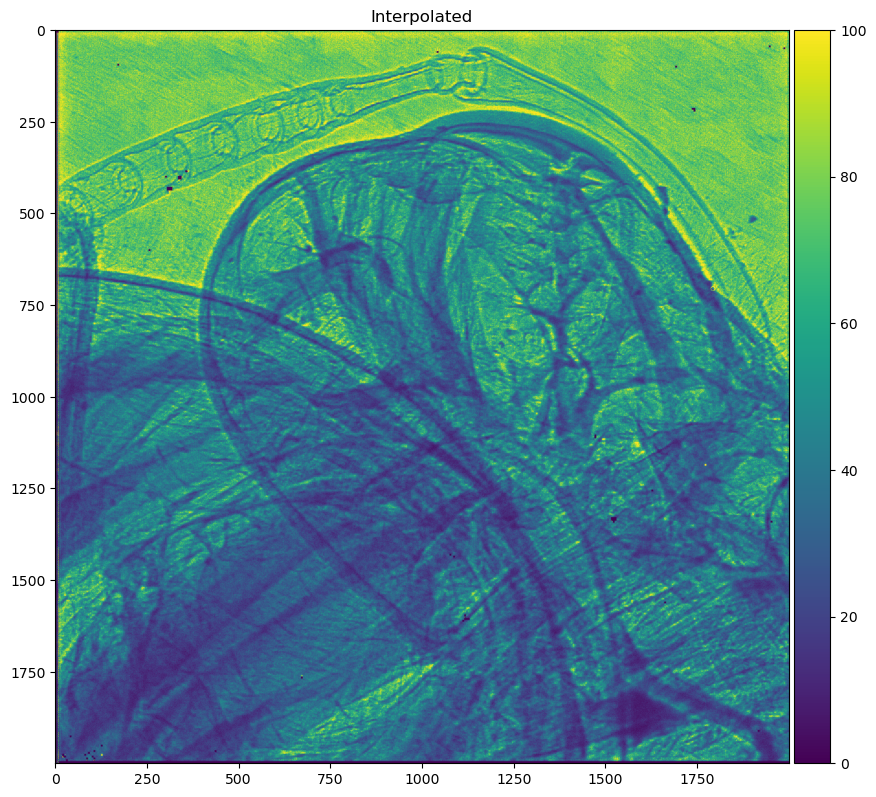

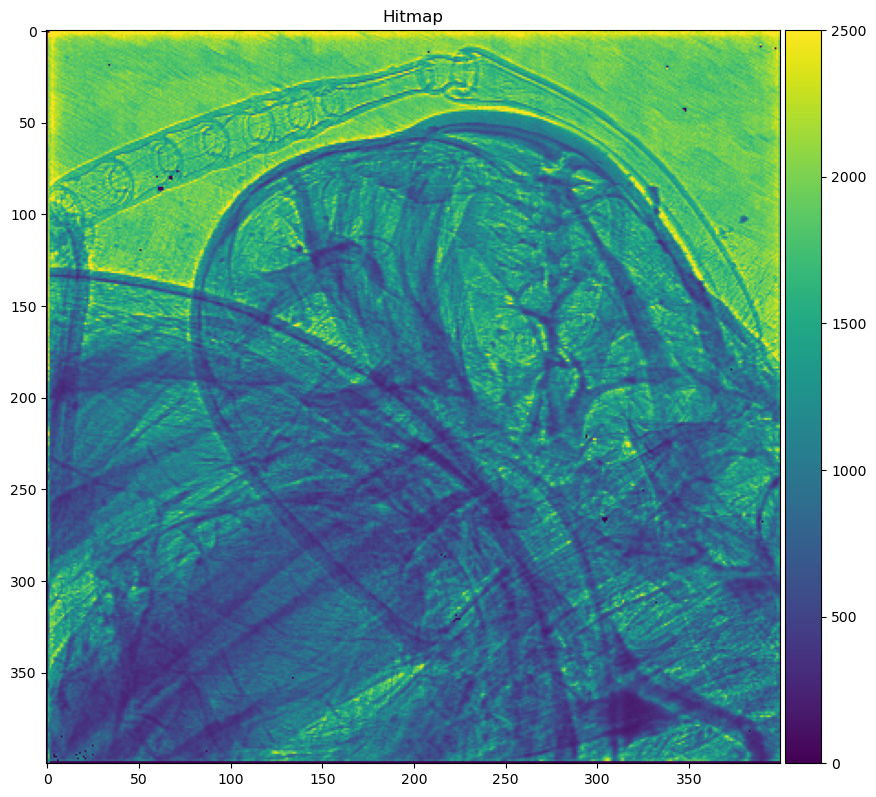

In [44]:
vis_index = 4
clim = np.array((0,100))
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(interpolated[:,:,vis_index])
im.set_clim(clim)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('Interpolated')

fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(hitmap[:,:,vis_index])
im.set_clim(clim*scale)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('Hitmap')

In [12]:
n_bins = 2000

Text(0.5, 1.0, 'Hitmap')

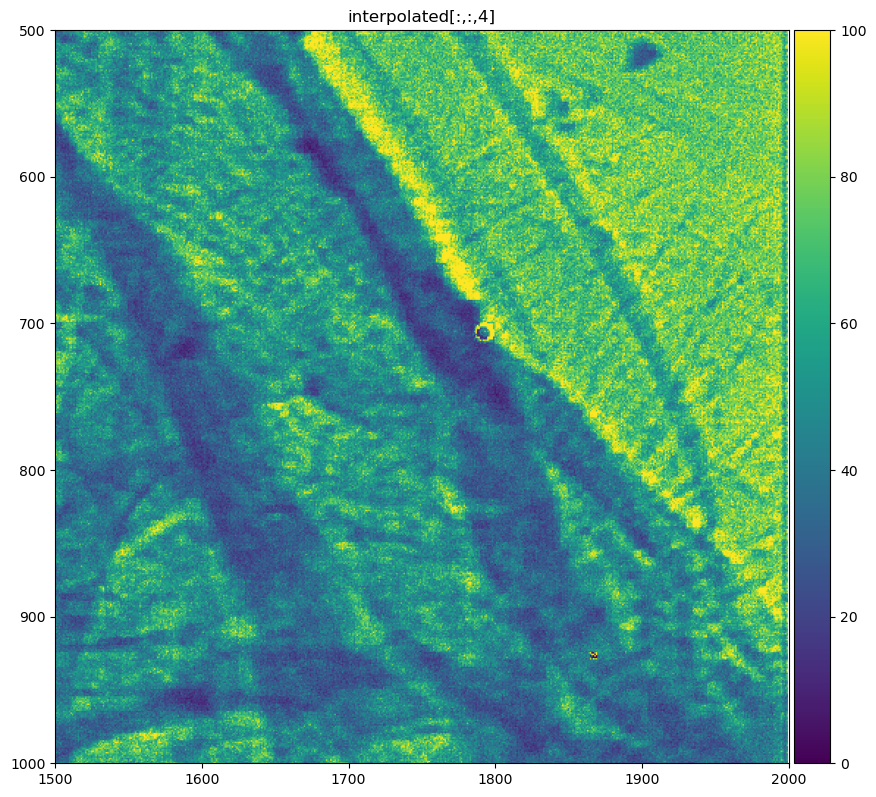

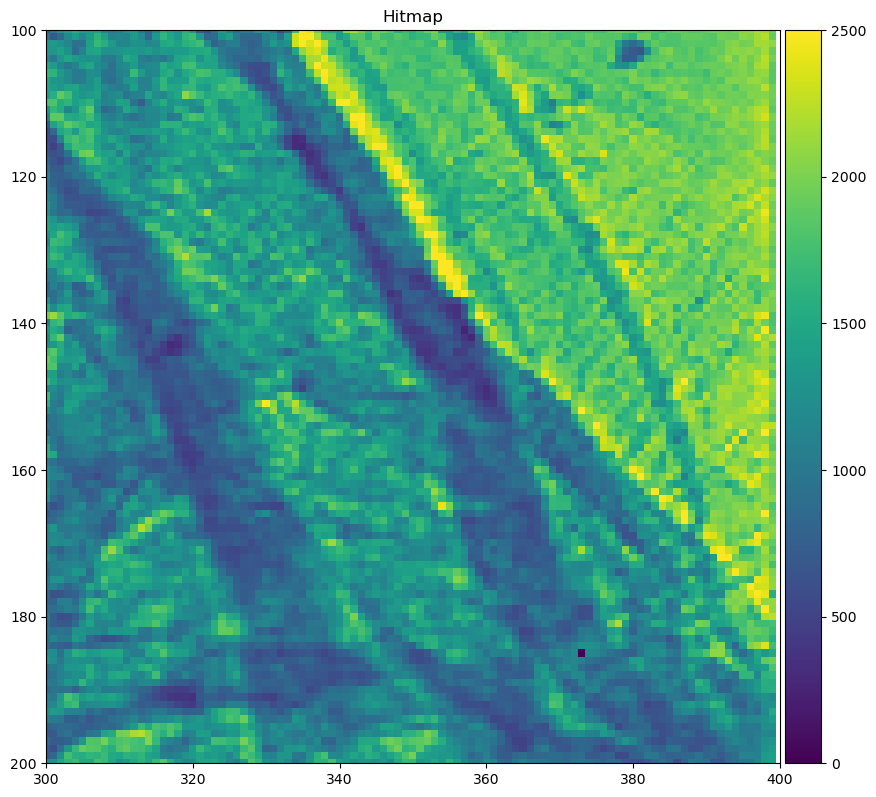

In [46]:
xlim = np.array((300,400))
ylim = np.array((200,100))
clim = np.array((0,100))
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(interpolated[:,:,vis_index])
im.set_clim(clim)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title(f'interpolated[:,:,{vis_index}]')
ax.set_xlim(xlim*n_bins/400)
ax.set_ylim(ylim*n_bins/400)


fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(hitmap[:,:,vis_index])
im.set_clim(clim*scale)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('Hitmap')